In [ ]:
# Import needed libraries
import gzip
import json
import pandas as pd
import numpy as np
import pickle
import json
from tqdm import tqdm
from re import escape
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Run this cell to mount the data drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading & Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IR/dataset_only_essential_features.csv.gz')

In [ ]:
data = data.drop(columns=['title']) #drop columns not needed
data['category'] = data['category'].str.replace('&amp;', '&', regex=False) #fix &amp

# replace all but the 11 categories with most counts with null, which are dropped in the next cell
top_categories = data['category'].value_counts().nlargest(11).index
data['category'] = data['category'].where(data['category'].isin(top_categories), other=pd.NA)

data_dropped = data.dropna() #drop null values

In [ ]:
# Filter out all users and items with less than 5 interactions, so after this don't remove any more samples, do that before this
while True:
    user_counts = data_dropped['user_id'].value_counts()
    valid_users = user_counts[user_counts >= 5].index
    data_dropped = data_dropped[data_dropped['user_id'].isin(valid_users)]

    item_counts = data_dropped['item_id'].value_counts()
    valid_items = item_counts[item_counts >= 5].index
    data_dropped = data_dropped[data_dropped['item_id'].isin(valid_items)]

    if len(valid_users) == len(user_counts) and len(valid_items) == len(item_counts):
        break

data_dropped.shape

(4997292, 9)

In [ ]:
def create_subsample(data, user_min_interactions=5, item_min_interactions=4, sample_fraction=0.1, random_state=42):
    """
    Create a representative subsample from the dataset while maintaining minimum user/item interactions.

    Args:
        data (pd.DataFrame): The full dataset.
        user_min_interactions (int): Minimum interactions per user.
        item_min_interactions (int): Minimum reviews per item.
        sample_fraction (float): Fraction of users/items to sample.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A smaller, filtered dataset.
    """
    np.random.seed(random_state)

    # Step 1: Sample a fraction of users
    unique_users = data['user_id'].unique()
    for i in range(5): # Check to see that not too many samples are rejected, we don't want to find the same sample every time
      if i == 4:
        print("Too many iterations")
        break
      sampled_users = np.random.choice(unique_users, size=int(len(unique_users) * sample_fraction), replace=True)

      # Create a DataFrame for sampled users
      sampled_users_df = pd.DataFrame({'user_id': sampled_users})
      # Add a unique instance ID for each sampled user
      sampled_users_df['instance_id'] = sampled_users_df.index

      # Merge sampled users with the original data
      data_sampled = sampled_users_df.merge(data, on='user_id', how='inner').copy()

      # Step 2: Filter users and items based on interaction thresholds
      while True:
          # Create a unique identifier for each sampled user-instance pair
          data_sampled['user_instance'] = data_sampled['user_id'].astype(str) + '_' + data_sampled['instance_id'].astype(str)
          # Filter users with at least user_min_interactions based on the unique identifier
          user_counts = data_sampled['user_instance'].value_counts()
          valid_users = user_counts[user_counts >= user_min_interactions].index
          data_sampled = data_sampled[data_sampled['user_instance'].isin(valid_users)].copy()

          # Filter items with at least item_min_interactions
          item_counts = data_sampled['item_id'].value_counts()
          valid_items = item_counts[item_counts >= item_min_interactions].index
          data_sampled = data_sampled[data_sampled['item_id'].isin(valid_items)].copy()

          # Break the loop if no further filtering is needed
          if len(valid_users) == len(user_counts) and len(valid_items) == len(item_counts):
              break

      # Drop the unique identifier column before returning the final dataframe
      data_sampled = data_sampled.drop(columns=['instance_id', 'user_instance'])

      # Enforce our sample to be a specific size so samples are not too different
      if len(data_sampled) < 58000 or len(data_sampled) > 65000:
        print("Rejected: ", len(data_sampled))
      else:
        break

    return data_sampled, len(valid_users)

In [ ]:
def leave_one_out_split_by_item(df):
    """Splits the dataset into train and test sets using a leave-one-out strategy
       by item for each user, ensuring the last interacted item is in the test set.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing the train and test DataFrames.
    """

    # Sort by user_id and unixReviewTime to ensure chronological order
    df = df.sort_values(by=['user_id', 'unixReviewTime'])

    # Group by user_id and get the index of the last item interacted with
    last_item_indices = df.groupby('user_id', observed=False).tail(1).index

    # Create the test set using the last item indices
    test_df = df.loc[last_item_indices].copy()

    # Create the train set by excluding the test set
    train_df = df.drop(index=last_item_indices).copy()

    # Ensure no overlap between train and test
    train_df = train_df[~train_df.index.isin(test_df.index)]

    return train_df, test_df

# Model definition

In [ ]:
class L2NormalizationLayer(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2NormalizationLayer, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim, eps=self.eps)


class DualAugmentedTwoTowerModel(nn.Module):
    def __init__(self, user_features_list, item_features_list, numeric_columns_user, numeric_columns_item, embedding_dim=32, d=32, num_dim=8):
        super(DualAugmentedTwoTowerModel, self).__init__()

        self.number_numeric_user = len(numeric_columns_user)
        self.number_numeric_item = len(numeric_columns_item)
        # Embedding layers for user and item categorical features
        self.user_feature_embeddings = nn.ModuleList([
            nn.Embedding(int(user_features_list[i+self.number_numeric_user]+1), embedding_dim) for i in range(len(user_features_list)-1-self.number_numeric_user)
        ])
        self.item_feature_embeddings = nn.ModuleList([
            nn.Embedding(int(item_features_list[i+self.number_numeric_item]+1), embedding_dim) for i in range(len(item_features_list)-1-self.number_numeric_item)
        ])

        self.a_u_embedding = nn.Embedding(int(user_features_list[-1]+1), d) #assume augmented user_id is last item
        self.a_v_embedding = nn.Embedding(int(item_features_list[-1]+1), d) #assume augmented item_id is first item

        self.numeric_fc = nn.Sequential(
            nn.Linear(1,num_dim),
            nn.ReLU()
        )

        # FC layers for user tower
        self.user_fc = nn.Sequential(
            nn.Linear(embedding_dim * (len(user_features_list)-self.number_numeric_user) + self.number_numeric_user * num_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            L2NormalizationLayer()
        )

        # FC layers for item tower
        self.item_fc = nn.Sequential(
            nn.Linear(embedding_dim * (len(item_features_list)-self.number_numeric_item) + self.number_numeric_item * num_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            L2NormalizationLayer()
        )

    def forward(self, user_features, item_features):
      user_numeric = [self.numeric_fc(user_features[i].unsqueeze(1).float()) for i in range(self.number_numeric_user)]
      user_numeric_embeds = torch.cat(user_numeric, dim=1)

      item_numeric = [self.numeric_fc(item_features[i].unsqueeze(1).float()) for i in range(self.number_numeric_item)]
      item_numeric_embeds = torch.cat(item_numeric, dim=1)

      user_feature_embeds = [embedding(user_features[i + self.number_numeric_user].long())
                            for i, embedding in enumerate(self.user_feature_embeddings)]
      item_feature_embeds = [embedding(item_features[i + self.number_numeric_item].long())
                            for i, embedding in enumerate(self.item_feature_embeddings)]

      user_augment = self.a_u_embedding(user_features[-1].long())
      item_augment = self.a_v_embedding(item_features[-1].long())

      user_embeds = torch.cat(user_feature_embeds, dim=1)
      item_embeds = torch.cat(item_feature_embeds, dim=1)

      augmented_user_embeds = torch.cat((user_numeric_embeds, user_embeds, user_augment), dim=1)
      augmented_item_embeds = torch.cat((item_numeric_embeds, item_embeds, item_augment), dim=1)

      user_out = self.user_fc(augmented_user_embeds)
      item_out = self.item_fc(augmented_item_embeds)

      dot_product = torch.sum(user_out * item_out, dim=1)

      return dot_product, user_augment, item_augment, user_out, item_out

Loss Functions

In [ ]:
def calculate_covariance(matrix):
    """Compute the covariance matrix for a given set of embeddings."""
    mean = torch.mean(matrix, dim=0, keepdim=True)
    centered_matrix = matrix - mean
    # For a single sample, just return outer product without normalization
    # For multiple samples, divide by N-1
    if matrix.size(0) == 1:
        covariance = torch.mm(centered_matrix.T, centered_matrix)
    else:
        covariance = torch.mm(centered_matrix.T, centered_matrix) / (matrix.size(0) - 1)
    return covariance

def category_alignment_loss(item_out, categories):
    """Compute the Category Alignment Loss (CAL)."""
    # Ensure categories is a LongTensor
    if categories.dtype != torch.long:
        categories = categories.long()

    # Get the unique categories that appear in this batch
    unique_categories = torch.unique(categories)

    # Build a dictionary with embeddings for each category
    category_sets = {cat.item(): item_out[categories == cat] for cat in unique_categories}

    # Determine the major category (largest set of items in the batch)
    major_category = max(category_sets, key=lambda c: category_sets[c].size(0))
    S_major = category_sets[major_category]
    C_major = calculate_covariance(S_major)

    # Compute CAL by comparing C_major with covariances of other categories
    cal_loss = 0.0
    for category, S_i in category_sets.items():
        if category != major_category and S_i.size(0) > 0:
            C_i = calculate_covariance(S_i)
            # Frobenius norm squared of the difference in covariance matrices
            cal_loss += torch.norm(C_major - C_i, p="fro") ** 2

    return cal_loss


# Separated the mimic loss equations in their own functions like in the paper.
def mimic_loss_user(labels, p_u, p_v, a_u):
    # According to the paper: y*a_u + (1-y)*p_v - p_v
    target = labels.unsqueeze(1) * a_u + (1 - labels).unsqueeze(1) * p_v
    return torch.mean((target - p_v)**2)

def mimic_loss_item(labels, p_u, p_v, a_v):
    # According to the paper: y*a_v + (1-y)*p_u - p_u
    target = labels.unsqueeze(1) * a_v + (1 - labels).unsqueeze(1) * p_u
    return torch.mean((target - p_u)**2)

def DAT_loss(predictions, labels, user_augment, item_augment, user_out, item_out, categories, l1=0.5, l2=0.5, l3=0): # set l3 to zero to run the model without CAL loss.
    BCE = F.binary_cross_entropy_with_logits(predictions, labels)
    # Apply stop gradient to user_out and item_out before calculating mimic loss
    user_mimic = mimic_loss_user(labels, user_out.detach(), item_out.detach(), user_augment)  # Gradient stopping
    item_mimic = mimic_loss_item(labels, user_out.detach(), item_out.detach(), item_augment)  # Gradient stopping
    CAL = category_alignment_loss(item_out, categories)
    return BCE + l1 * user_mimic + l2 * item_mimic + l3 * CAL

# Training Loop

In [ ]:
# Training Procedure
def negative_sampling(user_id, num_negatives, num_items, items):
    negatives = []
    for i in range(num_negatives):
        neg_item_idx = random.randint(0, len(items) - 1)
        negatives.append(items.iloc[neg_item_idx].values)

    negatives_df = pd.DataFrame(negatives)
    return negatives_df

def train_DAT(model, user_data, item_data, num_items, items_list, num_epochs=10, batch_size=256, num_negatives=5, learning_rate=0.05, patience=3):
    all_losses_per_sample = []
    # Move model to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Early stopping parameters
    min_delta = 1e-3
    best_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    smoothing_factor = 0.3

    for epoch in tqdm(range(num_epochs)):
        model.train()

        total_loss_per_sample = 0.0  # Sum of all losses, scaled by batch size
        total_samples = 0          # Total number of samples

        # Shuffle the data at the start of each epoch
        combined_data = pd.concat([user_data, item_data], axis=1)  # Combine the two datasets
        shuffled_data = combined_data.sample(frac=1,).reset_index(drop=True)  # Shuffle together
        user_data = shuffled_data.iloc[:, :len(user_data.columns)].copy()  # Split back to user_data
        item_data = shuffled_data.iloc[:, len(user_data.columns):].copy()  # Split back to item_data

        for batch_start in range(0, len(user_data), batch_size):
            user_batch_data = user_data.iloc[batch_start: batch_start + batch_size]
            item_batch_data = item_data.iloc[batch_start: batch_start + batch_size]

            item_batch_categories = item_batch_data['category']
            item_batch_categories_tensor = torch.tensor(item_batch_categories.values, dtype=torch.float32).to(device)

            batch_size_actual = len(user_batch_data)  # Handle variable batch sizes
            total_samples += batch_size_actual       # Track total samples

            user_ids = torch.tensor(user_batch_data['user_id'].values, dtype=torch.long).to(device)

            negative_samples = []
            for user_id in user_ids:
                neg_items = negative_sampling(user_id, num_negatives, num_items, items_list)
                negative_samples.extend(neg_items.values)

            negative_item_categories = [item[1] for item in negative_samples]
            negative_item_categories = torch.tensor(negative_item_categories, dtype=torch.float32).to(device)

            negative_samples_tensor = torch.tensor(np.array(negative_samples), dtype=torch.float32).to(device)

            user_batch_tensor = torch.tensor(user_batch_data.values, dtype=torch.float32).to(device)
            negative_user_batch_data = user_batch_tensor.repeat_interleave(num_negatives, dim=0)

            item_batch_tensor = torch.tensor(item_batch_data.values, dtype=torch.float32).to(device)

            # Combine positive and negative samples
            all_users = torch.cat([user_batch_tensor, negative_user_batch_data], dim=0)
            all_items = torch.cat([item_batch_tensor, negative_samples_tensor], dim=0)

            all_categories = torch.cat([item_batch_categories_tensor, negative_item_categories], dim=0)

            # Convert to long for embedding inputs
            all_users = all_users.to(torch.long)
            all_items = all_items.to(torch.long)

            # Labels: 1 for positive samples, 0 for negative samples
            labels = torch.cat([torch.ones(len(user_ids)), torch.zeros(len(user_ids) * num_negatives)]).to(device)

            predictions, user_augment, item_augment, user_out, item_out = model(all_users.T, all_items.T)

            # Compute loss
            loss = DAT_loss(predictions, labels, user_augment, item_augment, user_out, item_out, all_categories)

            # Accumulate total per-sample loss (scale batch-averaged loss by batch size)
            total_loss_per_sample += loss.item() * batch_size_actual

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute weighted average loss per sample
        avg_loss_per_sample = total_loss_per_sample / total_samples

        all_losses_per_sample.append(avg_loss_per_sample)

        # Step the scheduler
        scheduler.step(avg_loss_per_sample)

        # Print loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Weigthed Average Loss per Sample: {avg_loss_per_sample}')
            lr = scheduler.get_last_lr()[0]  # Get the current learning rate
            print(f"Current learning rate: {lr}")

        # Smooth loss computation
        if epoch == 0:
            smoothed_loss = avg_loss_per_sample
        else:
            smoothed_loss = smoothing_factor * avg_loss_per_sample + (1 - smoothing_factor) * smoothed_loss

        # Check for improvement
        if smoothed_loss < best_loss - min_delta:
            best_loss = smoothed_loss
            best_model_state = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Best Average Loss per Batch: {best_loss:.4f}")
            model.load_state_dict(best_model_state)
            break

    return all_losses_per_sample

# Evaluation Metrics

In [ ]:
# Extract all items every user has interected with in the training set
def get_interacted_items(df, user_id_col='user_id', item_id_col='item_id'):
    interacted_items = (
        df.groupby(user_id_col)[item_id_col]
        .apply(set)  # Collect all item_ids for each user into a set
        .to_dict()
    )
    return interacted_items

In [ ]:
def evaluation_metrics(model, users, interacted_items, items, test_items, K_list):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
      # Precompute all embeddings for users and items
      user_tensor = torch.tensor(users.values, dtype=torch.float32).T.to(device)
      item_tensor = torch.tensor(items.values, dtype=torch.float32).T.to(device)

      _, _, _, user_outputs, _ = model(user_tensor, item_tensor[:, :1])  # User embeddings
      _, _, _, _, item_outputs = model(user_tensor[:, :1], item_tensor)  # Item embeddings

      # Move to device for computation
      interacted_items = [torch.tensor(interacted, device=device) for interacted in interacted_items]
      test_item_indices = torch.tensor(test_items['item_id'].values, device=device)

      ranks = torch.zeros(len(users), device=device)
      hits = torch.zeros(len(K_list), device=device)

      # Compute all scores
      scores = torch.matmul(user_outputs, item_outputs.T)  # Shape: (num_users, num_items)

      for i, interacted in enumerate(interacted_items):
          # Mask interacted items
          scores[i, interacted] = float('-inf')

      # Get test item scores
      test_item_scores = scores[torch.arange(len(users), device=device), test_item_indices]

      # Compute ranks
      ranks = (scores > test_item_scores.unsqueeze(1)).sum(dim=1) + 1  # Rank is 1-based

      default_rank = len(items) + 1
      missing_items = torch.tensor([item_id not in items['item_id'].values for item_id in test_items['item_id'].values], device=device)

      # Count how many are True (missing items)
      num_missing = torch.sum(missing_items).item()

      # Count how many are False (present items)
      num_present = len(missing_items) - num_missing

      print(f"Number of missing items (True): {num_missing}")
      print(f"Number of present items (False): {num_present}")

      ranks[missing_items] = default_rank

      # Compute hit rates
      for k_idx, K in enumerate(K_list):
          hits[k_idx] = ((ranks <= K) & ~missing_items).sum().item()  # Exclude missing items from hits

      # Compute hit rates
      hitrates = [hit.item() / len(users) for hit in hits]

      # Compute MRR
      mrr = (1.0 / ranks).mean().item() * 10  # Include default rank in MRR

      return hitrates, mrr

In [ ]:
def training_eval_pipeline(train_user, train_item, all_items, test_user, test_item, interacted_items, data):
  # Metrics needed to initialize model
  max_user_features = train_user.max().tolist()
  max_item_features = all_items.max().tolist()
  numeric_columns_user = ["overall", "total_user_reviews", "average_rating"]
  numeric_columns_item = ["price", "books_rank"]
  model = DualAugmentedTwoTowerModel(max_user_features, max_item_features, numeric_columns_user, numeric_columns_item)  # Initialize the model
  model = model.to(device)  # Move model to the device (GPU/CPU)

  # Train the model
  all_sample_losses = train_DAT(model, train_user, train_item, data['item_id'].nunique(), all_items, num_epochs=50, batch_size=256, num_negatives=5, learning_rate=0.05)

  K_list = [50, 100]
  hitrates, mrr = evaluation_metrics(model, test_user, interacted_items, all_items, test_item, K_list)
  print("hitrate@50: ", hitrates[0])
  print("hitrate@100: ", hitrates[1])
  print("MRR: ", mrr)
  print("\n")
  # Flush GPU RAM
  del model
  torch.cuda.empty_cache()
  return hitrates, mrr, all_sample_losses

In [ ]:
def bootstrapping_pipeline(data, random_states, sample_fraction=0.035):
  # Lists to keep track of metrics for all bootrapping samples
  all_hitrates = []
  all_mrr = []
  all_sample_losses = []
  all_interactions = []
  all_users = []

  for index, random_state in enumerate(random_states):
    print(f"Sample: {index + 1}")
    sampled_data,  u = create_subsample(data, sample_fraction=sample_fraction, random_state=int(random_state))
    columns_one_hot = ['user_id', 'item_id', 'category']
    numeric_columns_user = ["overall", "total_user_reviews", "average_rating"]
    numeric_columns_item = ["price", "books_rank"]

    print(f"interactions: {len(sampled_data)}")
    print(f"users: {u}\n")
    all_interactions.append(len(sampled_data))
    all_users.append(u)

    for column in columns_one_hot:
        if column in sampled_data.columns:  # Ensure the column exists in the DataFrame
            unique_values = sampled_data[column].unique()  # Get unique values
            mapping = {old_value: new_value for new_value, old_value in enumerate(unique_values)}  # Create mapping
            sampled_data[column] = sampled_data[column].map(mapping)  # Apply mapping

    all_sample_items = sampled_data.drop(columns=['unixReviewTime', 'user_id', 'total_user_reviews', 'overall', 'average_rating'])
    all_sample_items = all_sample_items.drop_duplicates()
    all_sample_items['a_v'] = all_sample_items['item_id']

    train, test = leave_one_out_split_by_item(sampled_data)
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}\n")
    train_user = train.drop(columns=['item_id', 'unixReviewTime', 'price', 'books_rank', 'category'])
    test_user = test.drop(columns=['item_id', 'unixReviewTime', 'price', 'books_rank', 'category'])
    train_item = train.drop(columns=['user_id', 'overall', 'unixReviewTime', 'total_user_reviews', 'average_rating'])
    test_item = test.drop(columns=['user_id', 'overall', 'unixReviewTime', 'total_user_reviews', 'average_rating'])

    train_user['a_u'] = train_user['user_id']
    test_user['a_u'] = test_user['user_id']
    train_item['a_v'] = train_item['item_id']
    test_item['a_v'] = test_item['item_id']

    interacted_items = get_interacted_items(train)

    hitrates, mrr, sample_losses = training_eval_pipeline(train_user, train_item, all_sample_items, test_user, test_item, interacted_items, data)
    all_hitrates.append(hitrates)
    all_mrr.append(mrr)
    all_sample_losses.append(sample_losses)

  print(f"Mean Interactions: {np.mean(all_interactions)} +- {np.std(all_interactions)}")
  print(f"Mean Users: {np.mean(all_users)} +- {np.std(all_users)}\n")
  return all_hitrates, all_mrr, all_sample_losses

In [ ]:
num_samples = 35
random_states = np.linspace(15, 3242, num_samples)
all_hitrates, all_mrr, all_sample_losses = bootstrapping_pipeline(data_dropped, random_states)

Sample: 1
interactions: 58123
users: 4839

Train shape: (53375, 9)
Test shape: (4748, 9)



 10%|█         | 5/50 [02:38<23:38, 31.52s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48080911084360484
Current learning rate: 0.05


 20%|██        | 10/50 [05:15<20:56, 31.42s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47993467242377147
Current learning rate: 0.025


 28%|██▊       | 14/50 [07:51<20:12, 33.69s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4799274923527827
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4814


Number of missing items (True): 0
Number of present items (False): 4748
hitrate@50:  0.012005054759898905
hitrate@100:  0.03306655433866891
MRR:  0.024574953131377697


Sample: 2
interactions: 58824
users: 4970

Train shape: (53967, 9)
Test shape: (4857, 9)



 10%|█         | 5/50 [02:37<23:43, 31.62s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4764759133855314
Current learning rate: 0.05


 20%|██        | 10/50 [05:15<21:05, 31.63s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47662707163665663
Current learning rate: 0.025


 30%|███       | 15/50 [07:54<18:29, 31.69s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47456306847817464
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:00<17:47, 33.35s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4752


Number of missing items (True): 0
Number of present items (False): 4857
hitrate@50:  0.051472102120650606
hitrate@100:  0.0761787111385629
MRR:  0.08805075660347939


Sample: 3
interactions: 58152
users: 4939

Train shape: (53319, 9)
Test shape: (4833, 9)



 10%|█         | 5/50 [02:36<23:27, 31.29s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48032494395036185
Current learning rate: 0.05


 20%|██        | 10/50 [05:12<20:48, 31.21s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47837907187782497
Current learning rate: 0.05


 30%|███       | 15/50 [07:48<18:12, 31.23s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4759305169797046
Current learning rate: 0.05


 38%|███▊      | 19/50 [10:24<16:59, 32.87s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47587895926939294
Current learning rate: 0.025
Early stopping triggered. Best Average Loss per Batch: 0.4765


Number of missing items (True): 0
Number of present items (False): 4833
hitrate@50:  0.05193461618042624
hitrate@100:  0.07945375543140906
MRR:  0.08461683057248592


Sample: 4
Rejected:  56382
Rejected:  55919
interactions: 58058
users: 4810

Train shape: (53362, 9)
Test shape: (4696, 9)



 10%|█         | 5/50 [02:36<23:24, 31.22s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47783696186345476
Current learning rate: 0.05


 20%|██        | 10/50 [05:11<20:47, 31.18s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4755814439752846
Current learning rate: 0.05


 30%|███       | 15/50 [07:47<18:09, 31.13s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4738370551583935
Current learning rate: 0.025


 36%|███▌      | 18/50 [09:52<17:33, 32.92s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4750


Number of missing items (True): 0
Number of present items (False): 4696
hitrate@50:  0.048977853492333905
hitrate@100:  0.07921635434412266
MRR:  0.0784149020910263


Sample: 5
interactions: 59494
users: 4915

Train shape: (54691, 9)
Test shape: (4803, 9)



 10%|█         | 5/50 [02:40<24:04, 32.09s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48088175830682645
Current learning rate: 0.05


 20%|██        | 10/50 [05:21<21:25, 32.13s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47989695392282977
Current learning rate: 0.025


 28%|██▊       | 14/50 [08:01<20:37, 34.38s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4798857284743971
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4813


Number of missing items (True): 0
Number of present items (False): 4803
hitrate@50:  0.012075785967103894
hitrate@100:  0.029564855298771602
MRR:  0.027164157945662737


Sample: 6
interactions: 59591
users: 5010

Train shape: (54693, 9)
Test shape: (4898, 9)



 10%|█         | 5/50 [02:40<24:07, 32.18s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47740880725834633
Current learning rate: 0.05


 20%|██        | 10/50 [05:20<21:20, 32.00s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47578241686186457
Current learning rate: 0.025


 30%|███       | 15/50 [08:00<18:39, 31.98s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.474562656463011
Current learning rate: 0.025


 34%|███▍      | 17/50 [09:36<18:39, 33.93s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4758


Number of missing items (True): 0
Number of present items (False): 4898
hitrate@50:  0.05430788076766027
hitrate@100:  0.07676602694977541
MRR:  0.08361109532415867


Sample: 7
interactions: 59053
users: 4921

Train shape: (54246, 9)
Test shape: (4807, 9)



 10%|█         | 5/50 [02:38<23:43, 31.63s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808780149867549
Current learning rate: 0.05


 20%|██        | 10/50 [05:17<21:13, 31.84s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4794849018655827
Current learning rate: 0.025


 30%|███       | 15/50 [07:55<18:32, 31.80s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4761138889605249
Current learning rate: 0.0125


 40%|████      | 20/50 [10:33<15:44, 31.49s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47350722752533203
Current learning rate: 0.0125


 44%|████▍     | 22/50 [12:07<15:26, 33.09s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4746


Number of missing items (True): 0
Number of present items (False): 4807
hitrate@50:  0.052007489078427296
hitrate@100:  0.08425213230705221
MRR:  0.08978503756225109


Sample: 8
interactions: 61415
users: 4897

Train shape: (56637, 9)
Test shape: (4778, 9)



 10%|█         | 5/50 [02:45<24:55, 33.23s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48050613478524645
Current learning rate: 0.05


 20%|██        | 10/50 [05:30<21:59, 33.00s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4793949722585965
Current learning rate: 0.025


 30%|███       | 15/50 [08:17<19:24, 33.27s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47501223445115465
Current learning rate: 0.025


 40%|████      | 20/50 [11:03<16:37, 33.24s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4745761474600821
Current learning rate: 0.025


 44%|████▍     | 22/50 [12:43<16:12, 34.72s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4750


Number of missing items (True): 0
Number of present items (False): 4778
hitrate@50:  0.05295102553369611
hitrate@100:  0.08120552532440352
MRR:  0.09817376732826233


Sample: 9
Rejected:  56600
interactions: 60474
users: 4963

Train shape: (55621, 9)
Test shape: (4853, 9)



 10%|█         | 5/50 [02:42<24:19, 32.44s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47707035626417543
Current learning rate: 0.05


 20%|██        | 10/50 [05:26<21:45, 32.64s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47609055026192526
Current learning rate: 0.05


 30%|███       | 15/50 [08:09<19:02, 32.63s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4737929570831567
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:19<18:20, 34.39s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4751


Number of missing items (True): 0
Number of present items (False): 4853
hitrate@50:  0.05336905007212034
hitrate@100:  0.0783020811868947
MRR:  0.07906491868197918


Sample: 10
interactions: 59219
users: 4817

Train shape: (54510, 9)
Test shape: (4709, 9)



 10%|█         | 5/50 [02:38<23:47, 31.72s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808361208738482
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:06, 31.66s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47681164665301773
Current learning rate: 0.025


 30%|███       | 15/50 [07:55<18:28, 31.66s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4755491155787272
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:33<17:13, 33.34s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47417242756963235
Current learning rate: 0.025
Early stopping triggered. Best Average Loss per Batch: 0.4759


Number of missing items (True): 0
Number of present items (False): 4709
hitrate@50:  0.050966234869399024
hitrate@100:  0.08069653854321512
MRR:  0.07961621508002281


Sample: 11
interactions: 60042
users: 4952

Train shape: (55200, 9)
Test shape: (4842, 9)



 10%|█         | 5/50 [02:40<24:05, 32.12s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4806132637763369
Current learning rate: 0.05


 20%|██        | 10/50 [05:21<21:30, 32.25s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4784299661974976
Current learning rate: 0.05


 30%|███       | 15/50 [08:01<18:42, 32.07s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.48263286597486854
Current learning rate: 0.025


 30%|███       | 15/50 [08:33<19:59, 34.26s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4795


Number of missing items (True): 0
Number of present items (False): 4842
hitrate@50:  0.046468401486988845
hitrate@100:  0.0788930194134655
MRR:  0.06826252676546574


Sample: 12
interactions: 60335
users: 5069

Train shape: (55376, 9)
Test shape: (4959, 9)



 10%|█         | 5/50 [02:40<24:04, 32.09s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4764824361685417
Current learning rate: 0.05


 20%|██        | 10/50 [05:20<21:21, 32.04s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47620457932632876
Current learning rate: 0.05


 30%|███       | 15/50 [08:01<18:42, 32.08s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4743205015454737
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:08<18:02, 33.82s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4754


Number of missing items (True): 0
Number of present items (False): 4959
hitrate@50:  0.0544464609800363
hitrate@100:  0.08207299858842508
MRR:  0.08511326275765896


Sample: 13
Rejected:  54689
Rejected:  65349
Rejected:  57817
interactions: 60415
users: 4904

Train shape: (55645, 9)
Test shape: (4770, 9)



 10%|█         | 5/50 [02:41<24:13, 32.30s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47605487944912916
Current learning rate: 0.05


 20%|██        | 10/50 [05:24<21:36, 32.42s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4753297290644327
Current learning rate: 0.05


 30%|███       | 15/50 [08:07<19:00, 32.58s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4734101917910998
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:12<19:33, 34.51s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4750


Number of missing items (True): 0
Number of present items (False): 4770
hitrate@50:  0.05450733752620545
hitrate@100:  0.08134171907756814
MRR:  0.08577203378081322


Sample: 14
interactions: 62010
users: 4882

Train shape: (57231, 9)
Test shape: (4779, 9)



 10%|█         | 5/50 [02:45<24:50, 33.13s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808805530412362
Current learning rate: 0.05


 20%|██        | 10/50 [05:31<22:03, 33.08s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4799362838839008
Current learning rate: 0.025


 28%|██▊       | 14/50 [08:16<21:17, 35.49s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47992676093142544
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4813


Number of missing items (True): 0
Number of present items (False): 4779
hitrate@50:  0.015275162167817534
hitrate@100:  0.030759573132454487
MRR:  0.029075469356030226


Sample: 15
interactions: 58792
users: 4831

Train shape: (54063, 9)
Test shape: (4729, 9)



 10%|█         | 5/50 [02:37<23:32, 31.39s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4802878018300969
Current learning rate: 0.05


 20%|██        | 10/50 [05:14<20:57, 31.43s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47813037597590435
Current learning rate: 0.05


 30%|███       | 15/50 [07:51<18:16, 31.31s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47635407403428154
Current learning rate: 0.025


 40%|████      | 20/50 [10:28<15:43, 31.44s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4744655130075464
Current learning rate: 0.025


 42%|████▏     | 21/50 [11:31<15:55, 32.93s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4756


Number of missing items (True): 0
Number of present items (False): 4729
hitrate@50:  0.05075068724888983
hitrate@100:  0.08204694438570523
MRR:  0.08490709587931633


Sample: 16
interactions: 59530
users: 4914

Train shape: (54733, 9)
Test shape: (4797, 9)



 10%|█         | 5/50 [02:38<23:46, 31.71s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47610882136060007
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:06, 31.65s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47565652855505514
Current learning rate: 0.05


 30%|███       | 15/50 [07:55<18:34, 31.85s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4738767357101076
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:33<17:13, 33.33s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47390059906393583
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4743


Number of missing items (True): 0
Number of present items (False): 4797
hitrate@50:  0.054409005628517824
hitrate@100:  0.07817385866166354
MRR:  0.08679133839905262


Sample: 17
interactions: 62137
users: 5049

Train shape: (57198, 9)
Test shape: (4939, 9)



 10%|█         | 5/50 [02:44<24:46, 33.04s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47865056763779407
Current learning rate: 0.05


 20%|██        | 10/50 [05:30<22:03, 33.10s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4767773984433004
Current learning rate: 0.05


 30%|███       | 15/50 [08:14<19:11, 32.90s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47409764214317973
Current learning rate: 0.025


 40%|████      | 20/50 [10:59<16:29, 32.97s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47384553142534136
Current learning rate: 0.025


 40%|████      | 20/50 [11:33<17:19, 34.66s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4744


Number of missing items (True): 0
Number of present items (False): 4939
hitrate@50:  0.05446446649119255
hitrate@100:  0.0820004049402713
MRR:  0.07921023294329643


Sample: 18
interactions: 61779
users: 4983

Train shape: (56888, 9)
Test shape: (4891, 9)



 10%|█         | 5/50 [02:44<24:36, 32.81s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48089806185444606
Current learning rate: 0.05


 20%|██        | 10/50 [05:28<21:54, 32.87s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47993750787036127
Current learning rate: 0.025


 28%|██▊       | 14/50 [08:13<21:07, 35.22s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4799284779427005
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4813


Number of missing items (True): 0
Number of present items (False): 4891
hitrate@50:  0.02392148844817011
hitrate@100:  0.04354937640564302
MRR:  0.029922653920948505


Sample: 19
Rejected:  69621
Rejected:  56130
interactions: 60704
users: 4977

Train shape: (55847, 9)
Test shape: (4857, 9)



 10%|█         | 5/50 [02:42<24:25, 32.58s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808768720565526
Current learning rate: 0.05


 20%|██        | 10/50 [05:25<21:42, 32.56s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47950194464544493
Current learning rate: 0.025


 28%|██▊       | 14/50 [08:08<20:57, 34.92s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47984605371756744
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4813


Number of missing items (True): 0
Number of present items (False): 4857
hitrate@50:  0.01441218859378217
hitrate@100:  0.028412600370599134
MRR:  0.03348065773025155


Sample: 20
Rejected:  55377
Rejected:  54276
Rejected:  56594
interactions: 59805
users: 4880

Train shape: (55040, 9)
Test shape: (4765, 9)



 10%|█         | 5/50 [02:40<24:02, 32.06s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808753495992616
Current learning rate: 0.05


 20%|██        | 10/50 [05:19<21:20, 32.02s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4795139178287151
Current learning rate: 0.025


 30%|███       | 15/50 [08:00<18:46, 32.17s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47441620133643925
Current learning rate: 0.025


 40%|████      | 20/50 [10:40<16:02, 32.09s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47410398056340775
Current learning rate: 0.025


 42%|████▏     | 21/50 [11:44<16:12, 33.53s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4748


Number of missing items (True): 0
Number of present items (False): 4765
hitrate@50:  0.05099685204616999
hitrate@100:  0.08163693599160546
MRR:  0.08484102785587311


Sample: 21
Rejected:  56205
interactions: 63318
users: 5020

Train shape: (58417, 9)
Test shape: (4901, 9)



 10%|█         | 5/50 [02:49<25:23, 33.85s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47722688367703214
Current learning rate: 0.05


 20%|██        | 10/50 [05:39<22:37, 33.93s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4758342538243671
Current learning rate: 0.05


 28%|██▊       | 14/50 [08:28<21:47, 36.32s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47577064986577244
Current learning rate: 0.025
Early stopping triggered. Best Average Loss per Batch: 0.4773


Number of missing items (True): 0
Number of present items (False): 4901
hitrate@50:  0.05631503774739849
hitrate@100:  0.07712711691491532
MRR:  0.07823714055120945


Sample: 22
interactions: 61951
users: 4970

Train shape: (57105, 9)
Test shape: (4846, 9)



 10%|█         | 5/50 [02:44<24:40, 32.90s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47868293379852184
Current learning rate: 0.05


 20%|██        | 10/50 [05:29<22:00, 33.00s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4782044950283907
Current learning rate: 0.025


 30%|███       | 15/50 [08:15<19:24, 33.27s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4762958490423726
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:29<18:39, 34.97s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4769


Number of missing items (True): 0
Number of present items (False): 4846
hitrate@50:  0.0555096987205943
hitrate@100:  0.08027238959966983
MRR:  0.08689462207257748


Sample: 23
Rejected:  57822
interactions: 58668
users: 4874

Train shape: (53916, 9)
Test shape: (4752, 9)



 10%|█         | 5/50 [02:36<23:28, 31.29s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48082368322928976
Current learning rate: 0.05


 20%|██        | 10/50 [05:12<20:47, 31.19s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47993526078489224
Current learning rate: 0.025


 28%|██▊       | 14/50 [07:48<20:05, 33.48s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4799284712524847
Current learning rate: 0.00625
Early stopping triggered. Best Average Loss per Batch: 0.4814


Number of missing items (True): 0
Number of present items (False): 4752
hitrate@50:  0.010521885521885523
hitrate@100:  0.026725589225589225
MRR:  0.016831628745421767


Sample: 24
interactions: 58133
users: 4905

Train shape: (53337, 9)
Test shape: (4796, 9)



 10%|█         | 5/50 [02:34<23:09, 30.88s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.479044833327805
Current learning rate: 0.05


 20%|██        | 10/50 [05:08<20:32, 30.82s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4758784517436023
Current learning rate: 0.05


 30%|███       | 15/50 [07:43<18:00, 30.86s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47595379618905803
Current learning rate: 0.025


 40%|████      | 20/50 [10:16<15:22, 30.76s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4734519134328924
Current learning rate: 0.025


 40%|████      | 20/50 [10:47<16:11, 32.38s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4748


Number of missing items (True): 0
Number of present items (False): 4796
hitrate@50:  0.052752293577981654
hitrate@100:  0.07693911592994161
MRR:  0.07955193519592285


Sample: 25
interactions: 58845
users: 4847

Train shape: (54116, 9)
Test shape: (4729, 9)



 10%|█         | 5/50 [02:36<23:29, 31.32s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4753626687240861
Current learning rate: 0.05


 20%|██        | 10/50 [05:13<20:54, 31.36s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47389838272843765
Current learning rate: 0.025


 30%|███       | 15/50 [07:49<18:12, 31.21s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4738311578595847
Current learning rate: 0.0125


 30%|███       | 15/50 [08:20<19:27, 33.37s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4751


Number of missing items (True): 0
Number of present items (False): 4729
hitrate@50:  0.05476844998942694
hitrate@100:  0.07824064284203848
MRR:  0.10069863870739937


Sample: 26
interactions: 64930
users: 5136

Train shape: (59902, 9)
Test shape: (5028, 9)



 10%|█         | 5/50 [02:53<25:51, 34.49s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4806088667396138
Current learning rate: 0.05


 20%|██        | 10/50 [05:45<23:01, 34.53s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47627806510377146
Current learning rate: 0.025


 30%|███       | 15/50 [08:37<20:08, 34.51s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4753784074544039
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:47<20:47, 36.70s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4766


Number of missing items (True): 0
Number of present items (False): 5028
hitrate@50:  0.05409705648369133
hitrate@100:  0.07875894988066826
MRR:  0.10245742276310921


Sample: 27
interactions: 59899
users: 4926

Train shape: (55088, 9)
Test shape: (4811, 9)



 10%|█         | 5/50 [02:38<23:50, 31.79s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47988386036281216
Current learning rate: 0.05


 20%|██        | 10/50 [05:18<21:14, 31.87s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4763528035627421
Current learning rate: 0.05


 30%|███       | 15/50 [07:58<18:39, 32.00s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4747288479055044
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:38<17:21, 33.58s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4743636993952626
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4753


Number of missing items (True): 0
Number of present items (False): 4811
hitrate@50:  0.05009353564747454
hitrate@100:  0.08542922469341094
MRR:  0.07708887103945017


Sample: 28
interactions: 61821
users: 5077

Train shape: (56868, 9)
Test shape: (4953, 9)



 10%|█         | 5/50 [02:44<24:40, 32.91s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48025724650678686
Current learning rate: 0.05


 20%|██        | 10/50 [05:28<21:57, 32.94s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47791176959961335
Current learning rate: 0.025


 30%|███       | 15/50 [08:14<19:15, 33.00s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.475020794018819
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:26<18:33, 34.79s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4761


Number of missing items (True): 0
Number of present items (False): 4953
hitrate@50:  0.05249343832020997
hitrate@100:  0.07672117908338381
MRR:  0.08018741384148598


Sample: 29
Rejected:  56300
interactions: 58973
users: 4879

Train shape: (54212, 9)
Test shape: (4761, 9)



 10%|█         | 5/50 [02:37<23:44, 31.65s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48057317021965656
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:09, 31.74s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4767806389640022
Current learning rate: 0.05


 30%|███       | 15/50 [07:53<18:21, 31.47s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47464936358598137
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:31<17:10, 33.23s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47406393797742585
Current learning rate: 0.025
Early stopping triggered. Best Average Loss per Batch: 0.4754


Number of missing items (True): 0
Number of present items (False): 4761
hitrate@50:  0.05692081495484142
hitrate@100:  0.08485612266330603
MRR:  0.10017409920692444


Sample: 30
interactions: 60776
users: 4932

Train shape: (55962, 9)
Test shape: (4814, 9)



 10%|█         | 5/50 [02:42<24:26, 32.60s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48016214422171455
Current learning rate: 0.05


 20%|██        | 10/50 [05:24<21:36, 32.41s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.477824588161895
Current learning rate: 0.05


 30%|███       | 15/50 [08:07<18:55, 32.45s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47575007915275286
Current learning rate: 0.025


 36%|███▌      | 18/50 [10:17<18:18, 34.32s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4770


Number of missing items (True): 0
Number of present items (False): 4814
hitrate@50:  0.04860822600747819
hitrate@100:  0.07893643539675946
MRR:  0.07650914136320353


Sample: 31
Rejected:  57644
interactions: 59369
users: 4880

Train shape: (54594, 9)
Test shape: (4775, 9)



 10%|█         | 5/50 [02:39<23:52, 31.84s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808860144676488
Current learning rate: 0.05


 20%|██        | 10/50 [05:16<21:01, 31.53s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4786103223002681
Current learning rate: 0.05


 30%|███       | 15/50 [07:54<18:25, 31.60s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.4782372233819345
Current learning rate: 0.05


 30%|███       | 15/50 [08:26<19:41, 33.76s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4796


Number of missing items (True): 0
Number of present items (False): 4775
hitrate@50:  0.04649214659685864
hitrate@100:  0.07141361256544503
MRR:  0.07850579917430878


Sample: 32
interactions: 59760
users: 4931

Train shape: (54936, 9)
Test shape: (4824, 9)



 10%|█         | 5/50 [02:38<23:42, 31.62s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.48083303980957876
Current learning rate: 0.05


 20%|██        | 10/50 [05:17<21:12, 31.81s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.47600480628982283
Current learning rate: 0.025


 30%|███       | 15/50 [07:57<18:37, 31.93s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47535129977970364
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:35<17:17, 33.46s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.4749447053543289
Current learning rate: 0.0125
Early stopping triggered. Best Average Loss per Batch: 0.4756


Number of missing items (True): 0
Number of present items (False): 4824
hitrate@50:  0.04995854063018242
hitrate@100:  0.07711442786069651
MRR:  0.08497207425534725


Sample: 33
Rejected:  56058
interactions: 64729
users: 5072

Train shape: (59777, 9)
Test shape: (4952, 9)



 10%|█         | 5/50 [02:53<26:03, 34.73s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.47658098890572526
Current learning rate: 0.05


 20%|██        | 10/50 [05:46<23:11, 34.80s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4768386772665392
Current learning rate: 0.025


 30%|███       | 15/50 [08:40<20:15, 34.74s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47439239233393704
Current learning rate: 0.025


 32%|███▏      | 16/50 [09:50<20:55, 36.93s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4758


Number of missing items (True): 0
Number of present items (False): 4952
hitrate@50:  0.05189822294022617
hitrate@100:  0.07491922455573506
MRR:  0.07432342506945133


Sample: 34
interactions: 61265
users: 4923

Train shape: (56483, 9)
Test shape: (4782, 9)



 10%|█         | 5/50 [02:43<24:34, 32.76s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4808207207929036
Current learning rate: 0.05


 20%|██        | 10/50 [05:27<21:51, 32.79s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4777237945409148
Current learning rate: 0.05


 30%|███       | 15/50 [08:12<19:07, 32.78s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47571724123605524
Current learning rate: 0.025


 40%|████      | 20/50 [10:56<16:27, 32.91s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47468268799654745
Current learning rate: 0.025


 44%|████▍     | 22/50 [12:35<16:01, 34.33s/it]

Early stopping triggered. Best Average Loss per Batch: 0.4753


Number of missing items (True): 0
Number of present items (False): 4782
hitrate@50:  0.053534086156419906
hitrate@100:  0.08155583437892096
MRR:  0.07715468760579824


Sample: 35
interactions: 60084
users: 4953

Train shape: (55235, 9)
Test shape: (4849, 9)



 10%|█         | 5/50 [02:41<24:10, 32.22s/it]

Epoch 5/50, Weigthed Average Loss per Sample: 0.4793032965061621
Current learning rate: 0.05


 20%|██        | 10/50 [05:20<21:19, 31.99s/it]

Epoch 10/50, Weigthed Average Loss per Sample: 0.4778241418660189
Current learning rate: 0.05


 30%|███       | 15/50 [08:01<18:44, 32.14s/it]

Epoch 15/50, Weigthed Average Loss per Sample: 0.47587634983662297
Current learning rate: 0.025


 38%|███▊      | 19/50 [10:42<17:28, 33.82s/it]

Epoch 20/50, Weigthed Average Loss per Sample: 0.47551588741343326
Current learning rate: 0.025
Early stopping triggered. Best Average Loss per Batch: 0.4765


Number of missing items (True): 0
Number of present items (False): 4849
hitrate@50:  0.05238193441946793
hitrate@100:  0.07712930501134255
MRR:  0.07870468311011791


Mean Interactions: 60299.22857142857 +- 1711.4026174993637
Mean Users: 4938.4857142857145 +- 77.1408253700692



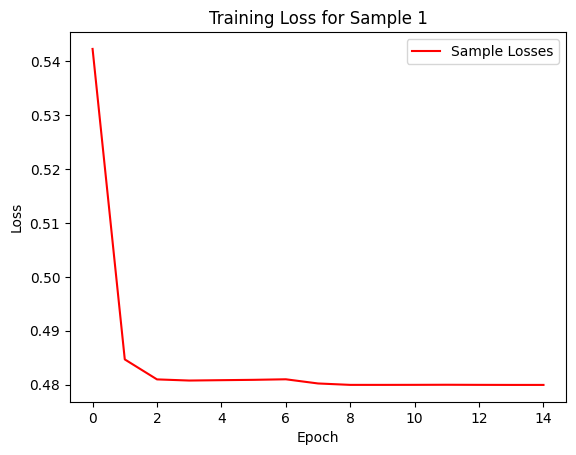

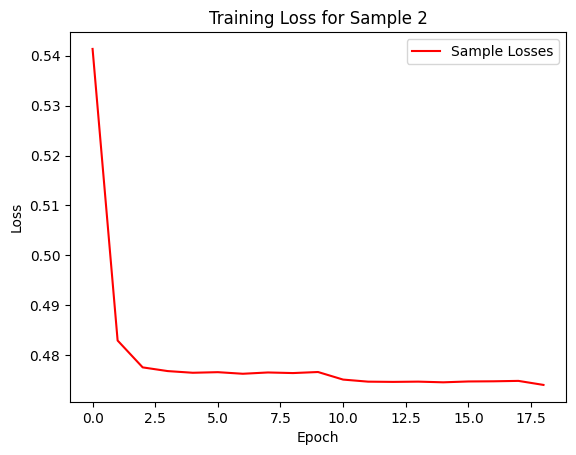

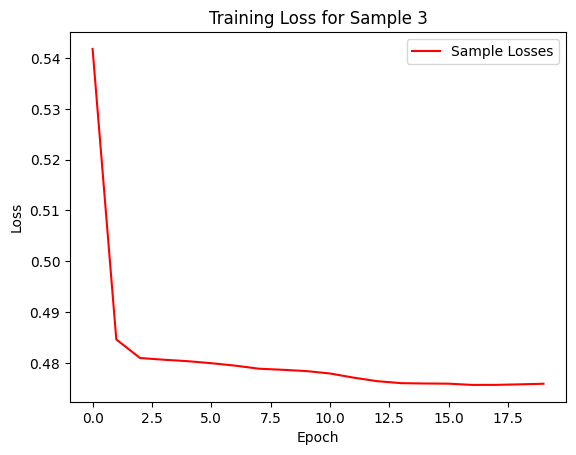

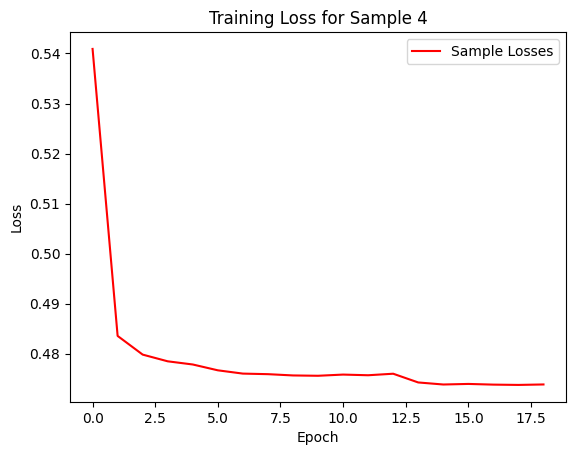

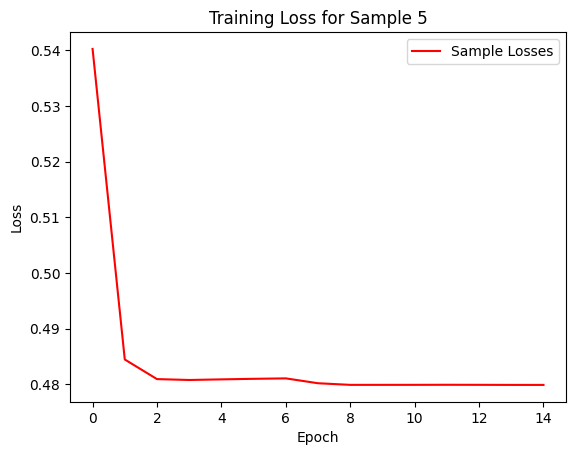

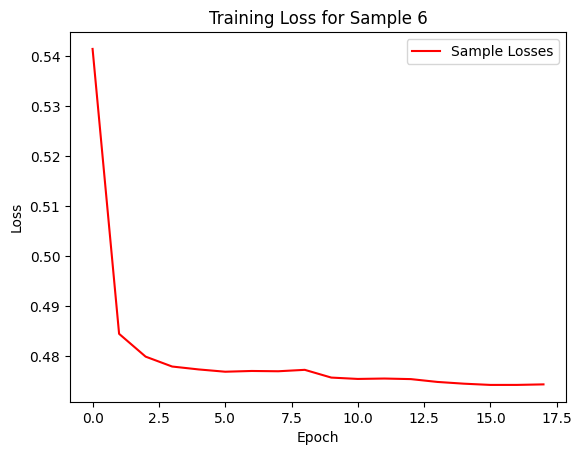

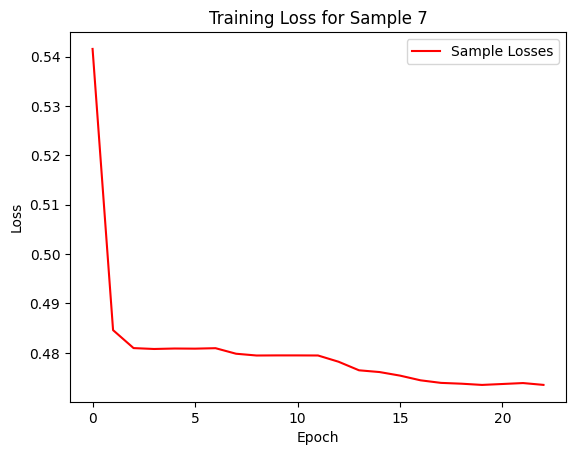

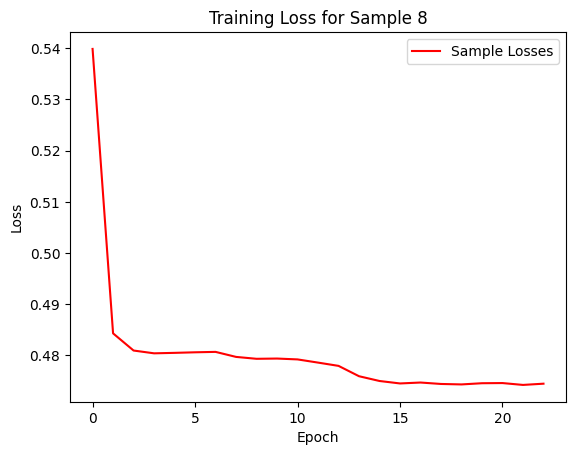

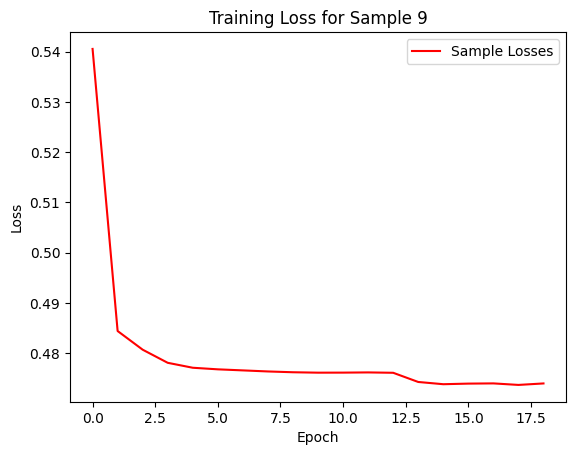

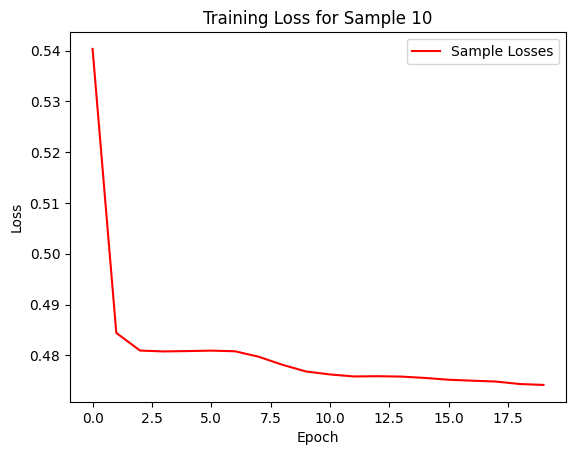

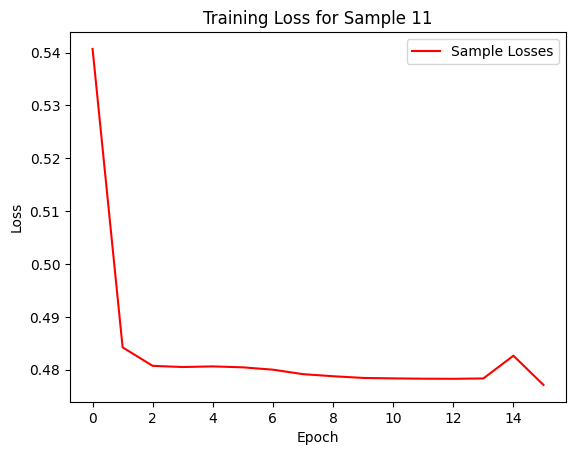

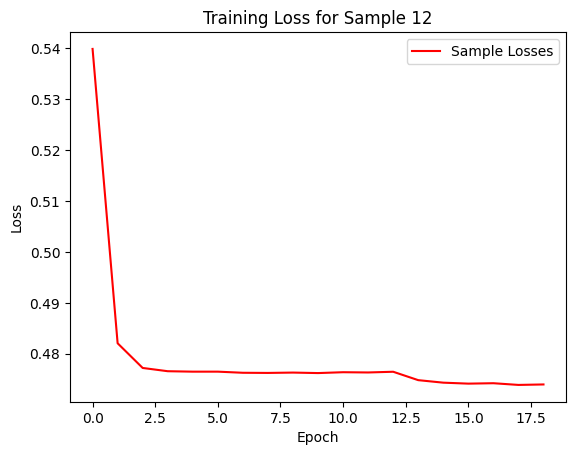

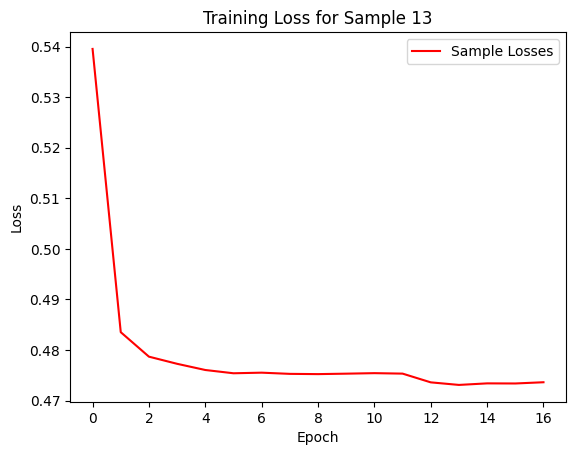

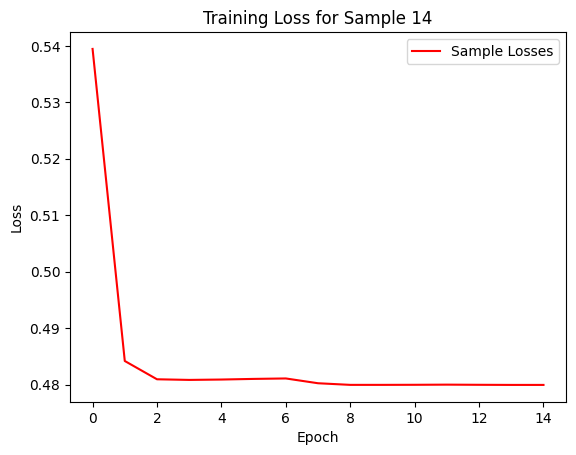

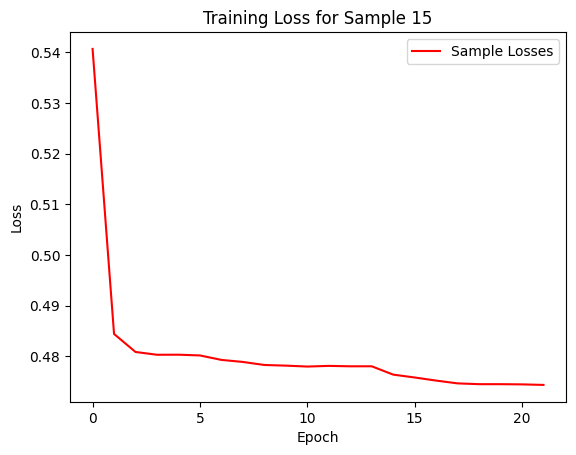

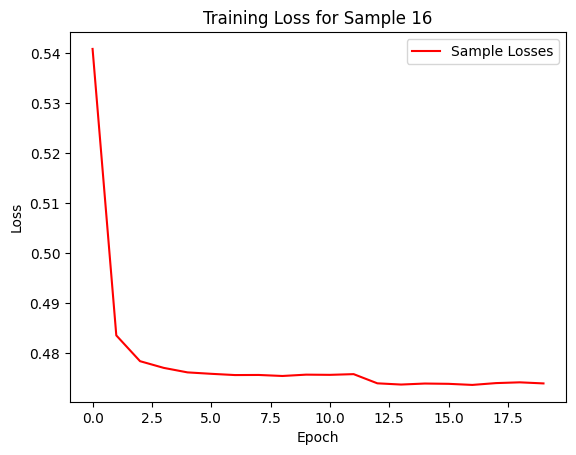

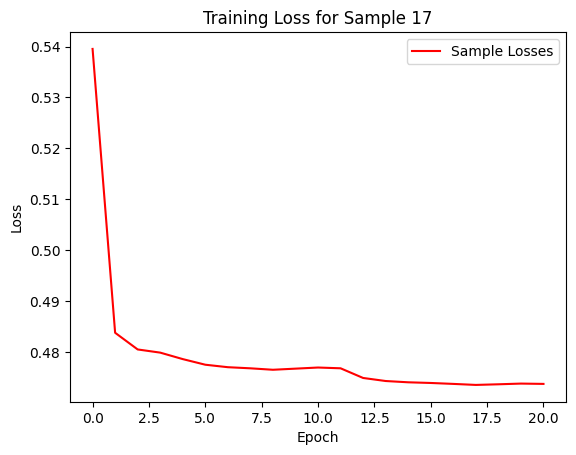

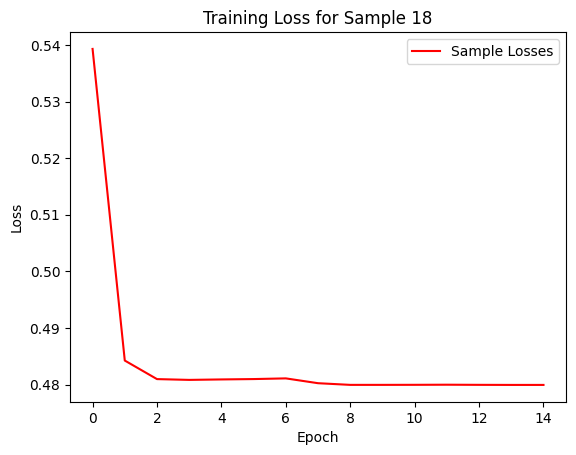

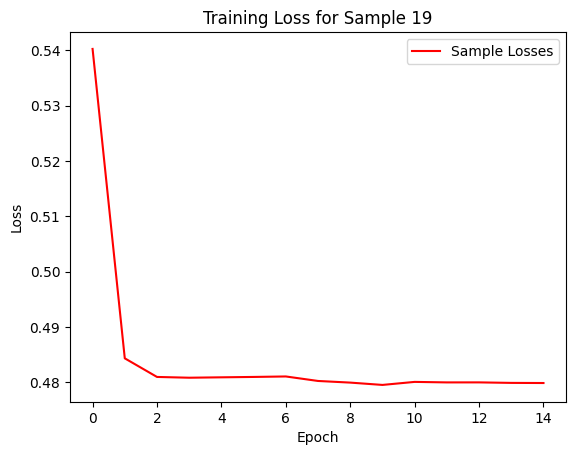

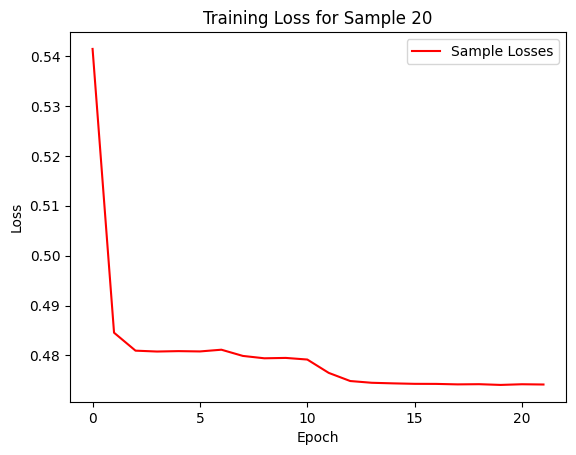

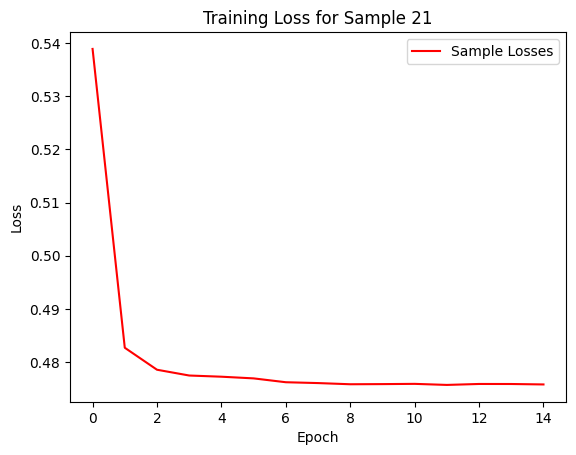

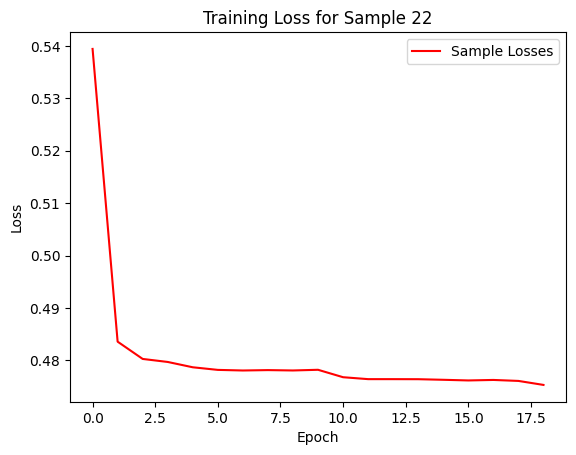

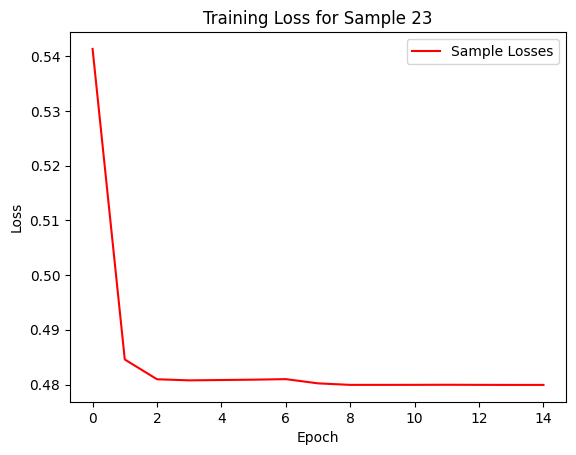

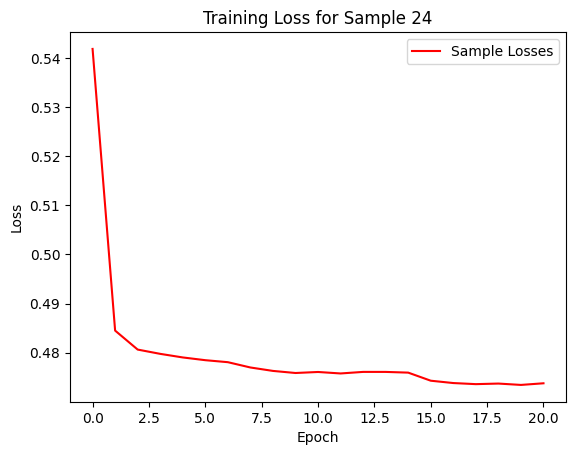

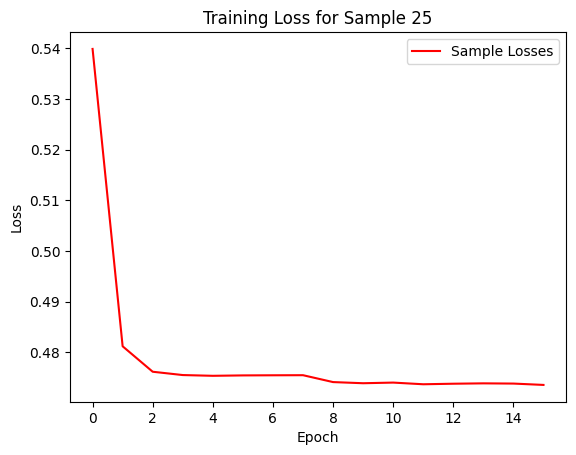

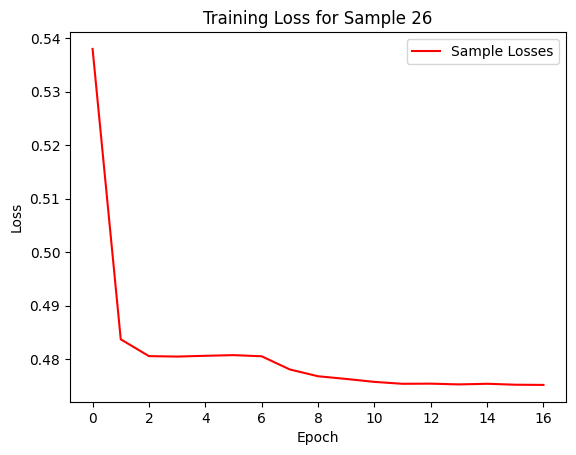

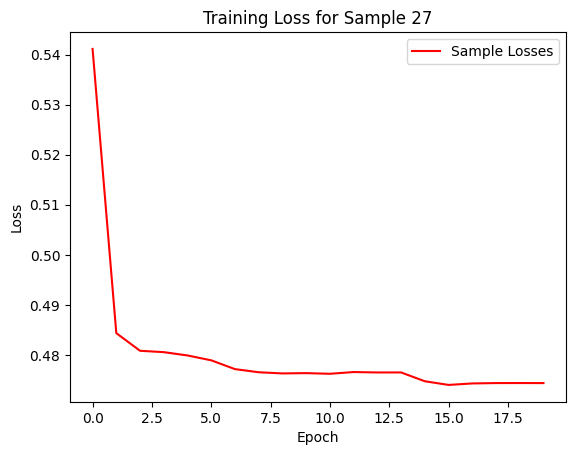

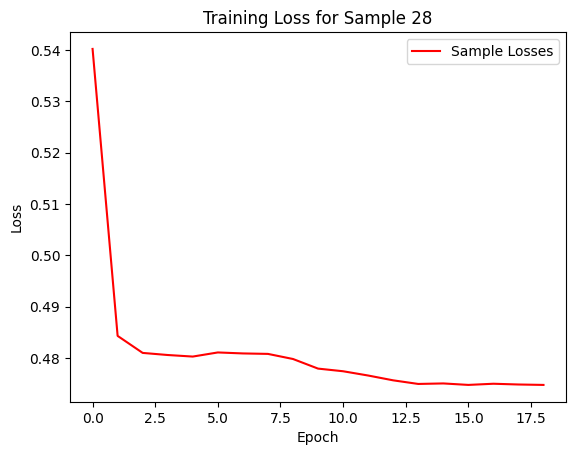

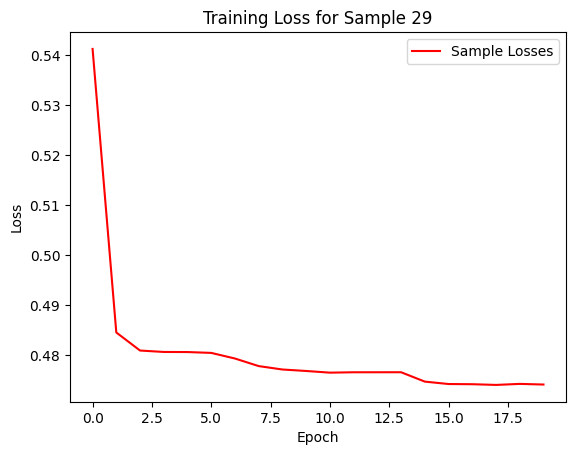

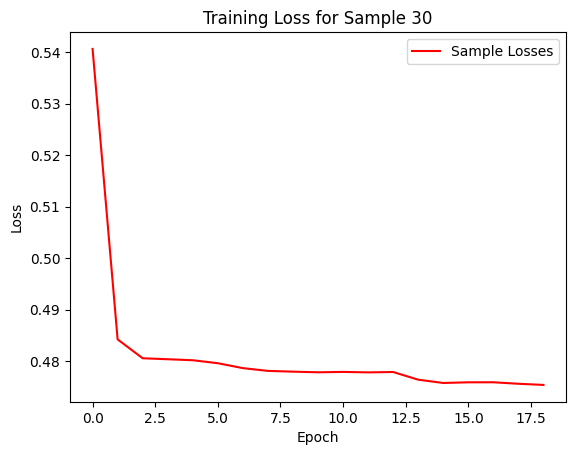

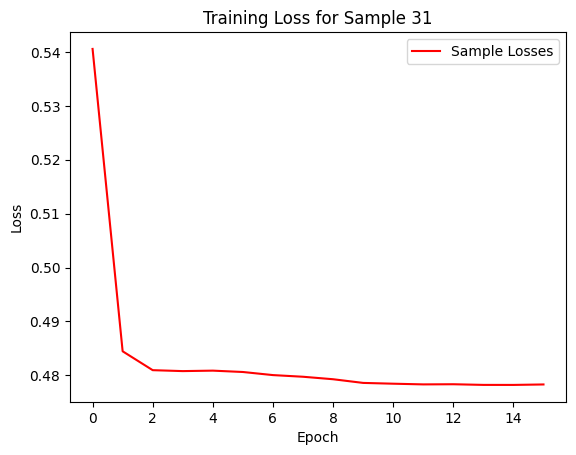

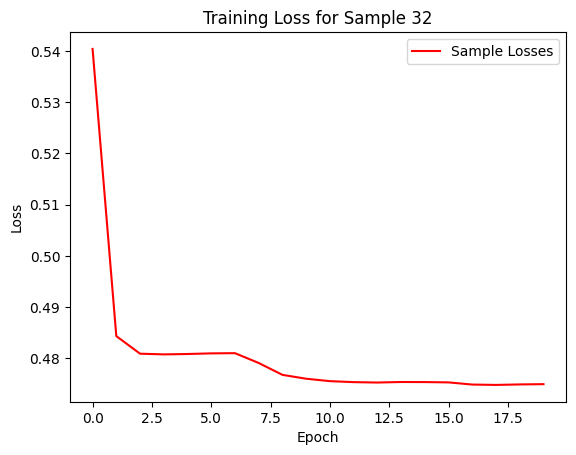

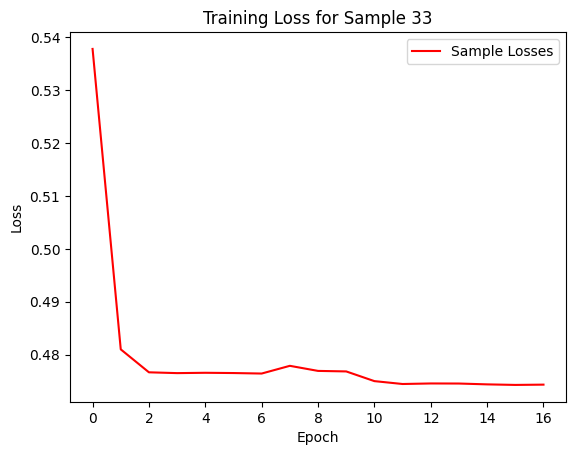

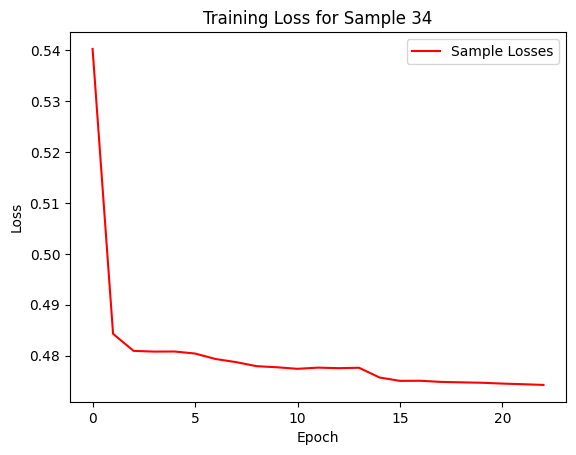

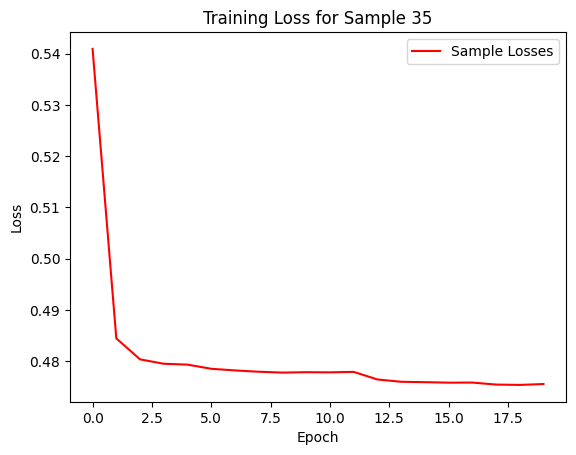

In [ ]:
for i, (sample_losses) in enumerate(all_sample_losses):
    plt.figure()  # Create a new figure for each sample

    # Plot sample losses
    plt.plot(sample_losses, label='Sample Losses', linestyle='solid', color='red')

    # Add labels, title, and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss for Sample {i+1}')
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
print(np.mean(all_hitrates), " +- ", np.std(all_hitrates))
print(np.mean(all_mrr), " +- ", np.std(all_mrr))

0.05856848068008178  +-  0.020772250132181532
0.07407830046888973  +-  0.02279853231370658


In [ ]:
hitrates_50 = [hit[0] for hit in all_hitrates]
hitrates_100 = [hit[1] for hit in all_hitrates]

In [ ]:
mean_hitrate_50 = np.mean(hitrates_50)
std_hitrate_50 = np.std(hitrates_50)
mean_hitrate_100 = np.mean(hitrates_100)
std_hitrate_100 = np.std(hitrates_100)
mean_mrr = np.mean(all_mrr)
std_mrr = np.std(all_mrr)

print(f"Mean Hitrate @ 50: {mean_hitrate_50} +- {std_hitrate_50}")
print(f"Mean Hitrate @ 100: {mean_hitrate_100} +- {std_hitrate_100}")
print(f"Mean MRR: {mean_mrr} += {std_mrr}")

Mean Hitrate @ 50: 0.045887557462103566 +- 0.014493687822600423
Mean Hitrate @ 100: 0.07124940389806 +- 0.01820148722188155
Mean MRR: 0.07407830046888973 += 0.02279853231370658


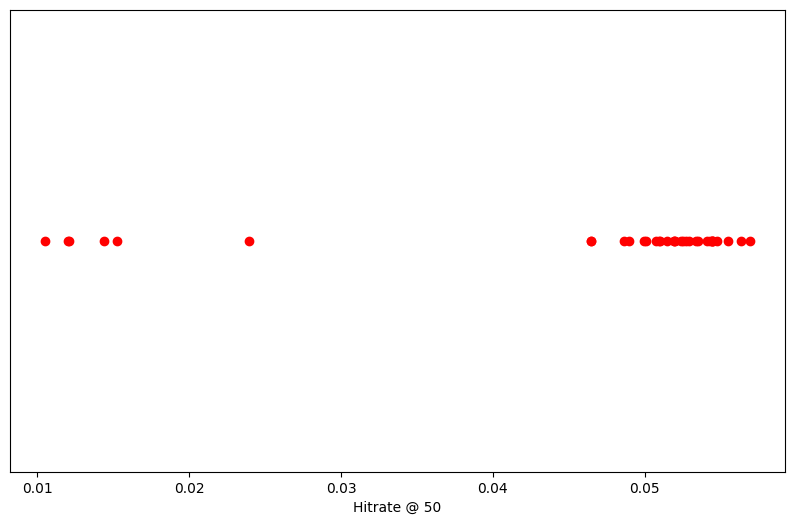

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(hitrates_50, np.zeros_like(hitrates_50), color='red', marker='o')
plt.xlabel('Hitrate @ 50')
plt.yticks([])
plt.show()

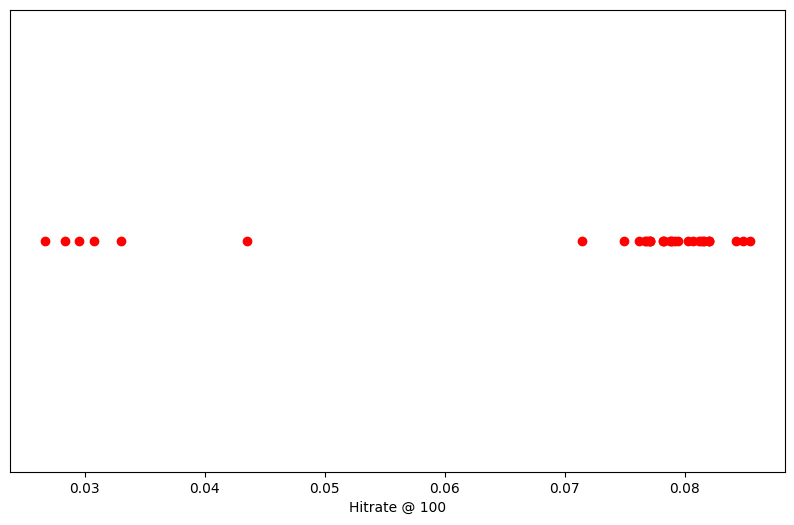

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(hitrates_100, np.zeros_like(hitrates_100), color='red', marker='o')
plt.xlabel('Hitrate @ 100')
plt.yticks([])
plt.show()

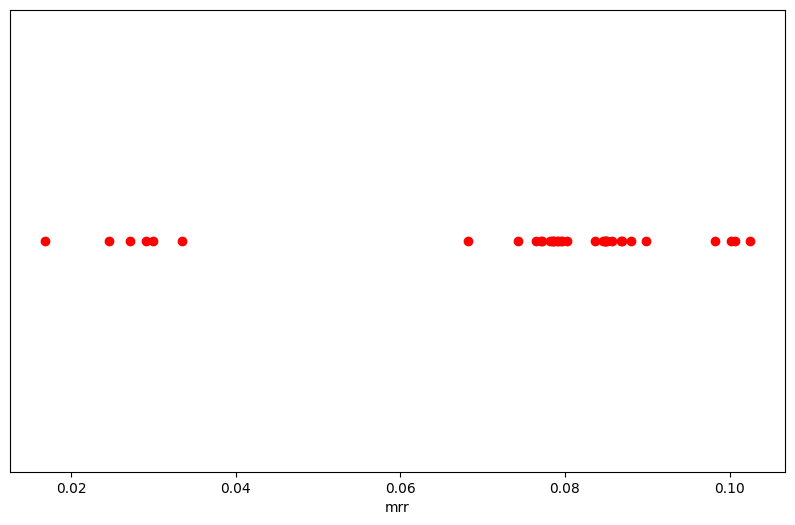

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(all_mrr, np.zeros_like(all_mrr), color='red', marker='o')
plt.xlabel('mrr')
plt.yticks([])
plt.show()

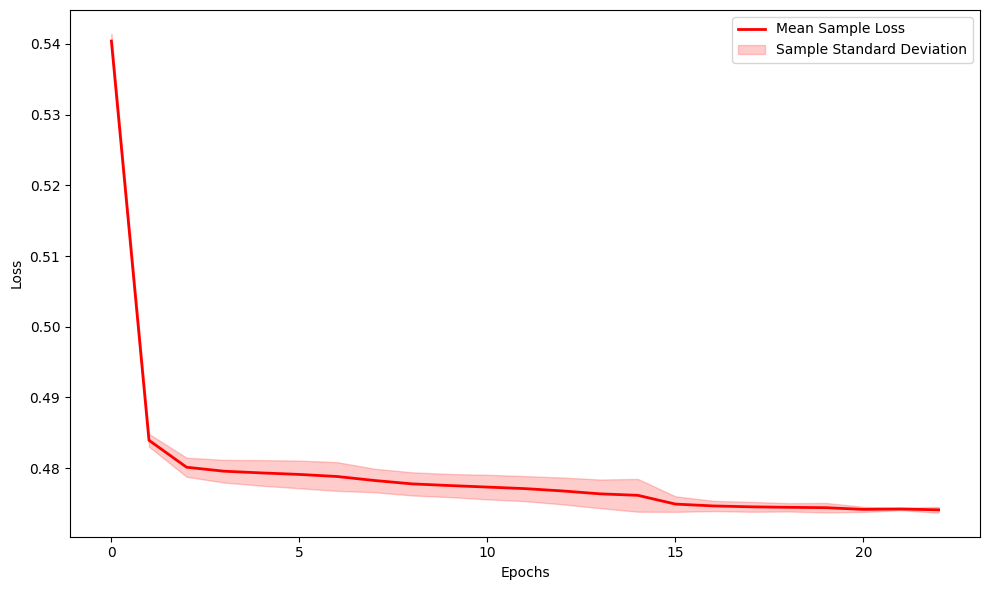

In [ ]:
max_length = max(len(curve) for curve in all_sample_losses)

padded_sample_losses = np.array([
    np.pad(curve, (0, max_length - len(curve)), constant_values=np.nan)
    for curve in all_sample_losses
])

#mean_batch_loss = np.nanmean(padded_batch_losses, axis=0)
#std_batch_loss = np.nanstd(padded_batch_losses, axis=0)
mean_sample_loss = np.nanmean(padded_sample_losses, axis=0)
std_sample_loss = np.nanstd(padded_sample_losses, axis=0)

plt.figure(figsize=(10, 6))
#plt.plot(mean_batch_loss, label='Mean Batch Loss', color='blue', linewidth=2)
plt.plot(mean_sample_loss, label='Mean Sample Loss', color='red', linewidth=2)

plt.fill_between(
    np.arange(max_length),
    mean_sample_loss - std_sample_loss,
    mean_sample_loss + std_sample_loss,
    color='red',
    alpha=0.2,
    label='Sample Standard Deviation'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title('Loss Curves with Mean and Standard Deviation')
plt.legend()
plt.tight_layout()

plt.show()